# Plotting CO Ice for the Filament

In [1]:
print('test')

test


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import simple_norm
import astropy.units as u 
from astropy.coordinates import SkyCoord
import regions
from regions import Regions

from spectral_cube import SpectralCube
import importlib as imp

from dust_extinction.averages import CT06_MWLoc, I05_MWAvg, CT06_MWGC, G21_MWAvg, RL85_MWGC, RRP89_MWGC, F11_MWGC

In [20]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [22]:
from jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
import cutout_manager as cm
import jwst_plots
import co_ice as co_map
imp.reload(co_map)
import extinction as ex

In [23]:
cd notebooks

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


## Catalog

In [6]:
cat_use = make_cat_use()

In [7]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)

cutout_filament = cm.Cutout(pos, w, l)
cutout_405 = cutout_filament.get_cutout_405()

In [62]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], cutout_405.wcs))
mask_red = (cat_filament.color('f182m', 'f212n') > 0.5) | (np.isnan(np.array(cat_filament.band('f182m'))) & np.isnan(np.array(cat_filament.band('f187n'))))
mask_red = mask_red & (cat_filament.color('f410m', 'f466n') < 0)
cat_filament = JWSTCatalog(cat_filament.catalog[mask_red])

In [63]:
reg_f = Regions.read('/orange/adamginsburg/jwst/cloudc/lactea-filament/lactea-filament/regions_/filament_short.region')
cat_f = JWSTCatalog(cat_use.table_region_mask(reg_f, cutout_405.wcs))
mask_red = (cat_f.color('f182m', 'f212n') > 0.5) | (np.isnan(np.array(cat_f.band('f182m'))) & np.isnan(np.array(cat_f.band('f187n')))) 
mask_red = mask_red & (cat_f.color('f410m', 'f466n') < 0)
cat_f = JWSTCatalog(cat_f.catalog[mask_red])

(0.0, 3.0)

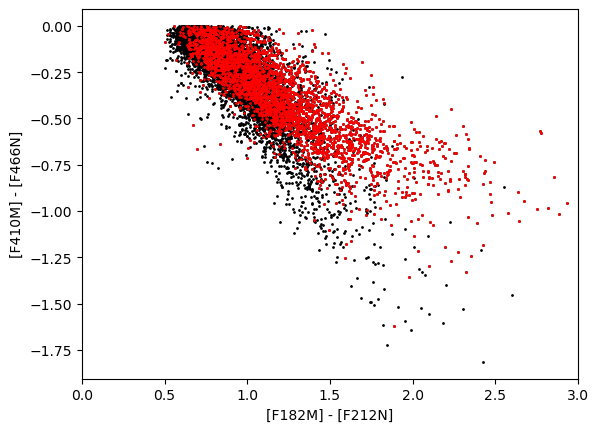

In [64]:
ax = plt.subplot(111)
cat_filament.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='k', s=1)
cat_f.plot_CCD('f182m', 'f212n', 'f410m', 'f466n', ax=ax, color='r', s=1)
ax.set_xlim(0, 3)

## CO Ice

In [66]:
Av_182212 = cat_filament.get_Av('f182m', 'f212n', ext=CT06_MWLoc())
cat_filament.catalog['N(CO)'] = co_map.get_co_column(cat_filament, Av_182212, ext=CT06_MWLoc(), consts_file='1_CO_(1)_12.5K_Baratta.txt')

In [67]:
co_col_map = co_map.make_co_column_map(cat_filament, cat_filament.catalog['N(CO)'], cutout_405.wcs, cutout_405.shape, fwhm=30, k=5)

In [68]:
dmag_466m410, cols = co_map.co_ice_modeling(ref_band='f410m', consts_file='1_CO_(1)_12.5K_Baratta.txt')

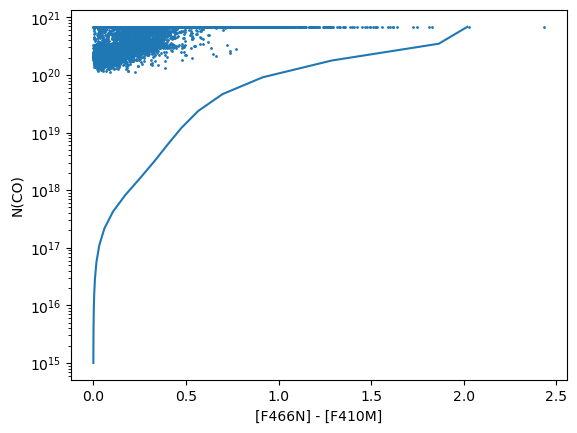

In [69]:
plt.semilogy(dmag_466m410[cols<1e21], cols[cols<1e21])
plt.scatter(cat_filament.color('f466n', 'f410m'), cat_filament.catalog['N(CO)'], s=1)
plt.xlabel('[F466N] - [F410M]')
plt.ylabel('N(CO)')
#plt.plot([0.25, 1.75], [9e17, 6e19])
plt.yscale('log')
#plt.title(os.path.basename(os.path.normpath(consts_file)))

Text(0, 0.5, 'N(CO) (cm$^{-2}$)')

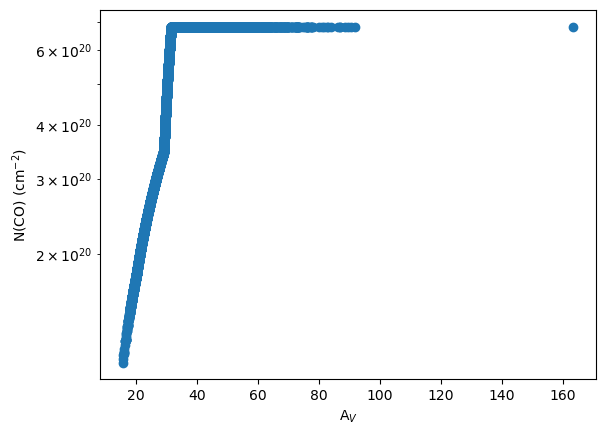

In [70]:
plt.scatter(Av_182212, cat_filament.catalog['N(CO)'])
plt.yscale('log')
plt.xlabel('A$_V$')
#plt.ylim(1e19, 1e22)
plt.ylabel('N(CO) (cm$^{-2}$)')

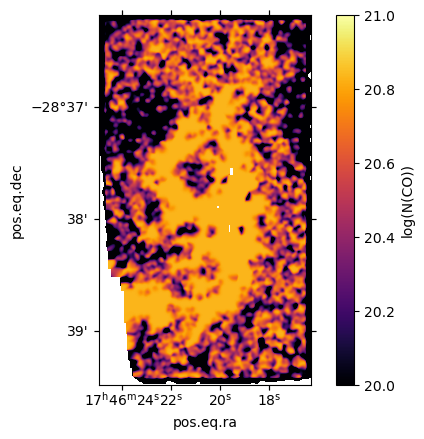

In [52]:
co_col_map[co_col_map < 1e16] = np.nan
ax = plt.subplot(projection=cutout_405.wcs)
im = ax.imshow(np.log10(co_col_map), origin='lower', cmap='inferno', vmin=20, vmax=21)
plt.colorbar(im, ax=ax, label='log(N(CO))')

In [44]:
from icemodels.core import composition_to_molweight

In [45]:
composition_to_molweight('CO')

28.010145